In [2]:
import os
os.listdir("../data")


['init', 'synthetic_session1.csv']

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os

def simulate_session(start_percent=90, minutes=240, base_drain_per_min=0.08, seed=1):
    np.random.seed(seed)
    times = [datetime.now() + timedelta(minutes=i) for i in range(minutes)]
    
    cpu = np.clip(np.random.normal(loc=20, scale=10, size=minutes), 0, 100)
    screen_on = (np.random.rand(minutes) < 0.35).astype(int)
    
    drain = base_drain_per_min + (cpu/100)*0.18 + screen_on*0.45 + np.random.normal(0, 0.02, minutes)
    percent = np.maximum(0, start_percent - np.cumsum(drain))
    
    df = pd.DataFrame({
        "timestamp": times,
        "battery_percent": np.round(percent, 3),
        "cpu_pct": np.round(cpu, 2),
        "screen_on": screen_on,
        "drain_per_min": np.round(drain, 4),
    })
    
    minutes_remaining = []
    for i in range(len(df)):
        curr = df.loc[i, "battery_percent"]
        future = df.loc[i:, "drain_per_min"].values
        avg_future = future.mean() if len(future) > 0 else np.nan
        rem = int(np.ceil(curr / avg_future)) if avg_future and avg_future > 0 else 0
        minutes_remaining.append(rem)
    
    df["minutes_remaining_target"] = minutes_remaining
    return df

light = simulate_session(start_percent=95, minutes=300, base_drain_per_min=0.03, seed=101)
heavy = simulate_session(start_percent=95, minutes=300, base_drain_per_min=0.12, seed=303)

light.to_csv("../data/synthetic_session_light.csv", index=False)
heavy.to_csv("../data/synthetic_session_heavy.csv", index=False)

print(os.listdir("../data"))


['init', 'synthetic_session1.csv', 'synthetic_session_heavy.csv', 'synthetic_session_light.csv']


In [4]:
import pandas as pd

light = pd.read_csv("../data/synthetic_session_light.csv", parse_dates=["timestamp"])
medium = pd.read_csv("../data/synthetic_session1.csv", parse_dates=["timestamp"])
heavy = pd.read_csv("../data/synthetic_session_heavy.csv", parse_dates=["timestamp"])

light["session"] = "light"
medium["session"] = "medium"
heavy["session"] = "heavy"

df = pd.concat([light, medium, heavy], ignore_index=True)

df.head()


,timestamp,battery_percent,cpu_pct,screen_on,drain_per_min,minutes_remaining_target,session
0,2025-12-05 19:08:25.739883,94.451,47.07,1,0.5491,435,light
1,2025-12-05 19:09:25.739977,94.401,26.28,0,0.0497,437,light
2,2025-12-05 19:10:25.739984,94.281,29.08,0,0.1207,436,light
3,2025-12-05 19:11:25.739988,93.721,25.04,1,0.5598,432,light
4,2025-12-05 19:12:25.739992,93.649,26.51,0,0.0717,434,light


In [5]:
df = df.sort_values("timestamp").reset_index(drop=True)
df.head()


,timestamp,battery_percent,cpu_pct,screen_on,drain_per_min,minutes_remaining_target,session
0,2025-12-03 19:18:39.320908,94.478,24.97,1,0.5216,378,medium
1,2025-12-03 19:19:39.320926,93.924,18.62,1,0.5544,377,medium
2,2025-12-03 19:20:39.320931,93.830,26.48,0,0.0944,379,medium
3,2025-12-03 19:21:39.320934,93.695,35.23,0,0.1348,377,medium
4,2025-12-03 19:22:39.320938,93.618,17.66,0,0.0765,376,medium


In [6]:
import numpy as np

# Battery drop per step (how fast it is dropping)
df["battery_drop"] = -df["battery_percent"].diff().fillna(0)

# Rolling std of drain (volatility)
df["roll_drain_std_5"] = df["drain_per_min"].rolling(5, min_periods=1).std().fillna(0)

# CPU × Screen interaction (high when CPU high & screen on)
df["cpu_screen_interaction"] = df["cpu_pct"] * df["screen_on"]

# Cumulative drain
df["cumulative_drain"] = df["drain_per_min"].cumsum()

# Rolling min/max
df["roll_drain_min_5"] = df["drain_per_min"].rolling(5, min_periods=1).min()
df["roll_drain_max_5"] = df["drain_per_min"].rolling(5, min_periods=1).max()

# (Optional) check columns
df.head()


,timestamp,battery_percent,cpu_pct,screen_on,drain_per_min,minutes_remaining_target,session,battery_drop,roll_drain_std_5,cpu_screen_interaction,cumulative_drain,roll_drain_min_5,roll_drain_max_5
0,2025-12-03 19:18:39.320908,94.478,24.97,1,0.5216,378,medium,-0.000,0.000000,24.97,0.5216,0.5216,0.5216
1,2025-12-03 19:19:39.320926,93.924,18.62,1,0.5544,377,medium,0.554,0.023193,18.62,1.0760,0.5216,0.5544
2,2025-12-03 19:20:39.320931,93.830,26.48,0,0.0944,379,medium,0.094,0.256637,0.00,1.1704,0.0944,0.5544
3,2025-12-03 19:21:39.320934,93.695,35.23,0,0.1348,377,medium,0.135,0.245372,0.00,1.3052,0.0944,0.5544
4,2025-12-03 19:22:39.320938,93.618,17.66,0,0.0765,376,medium,0.077,0.240074,0.00,1.3817,0.0765,0.5544


In [7]:
features = [
    "battery_percent",
    "cpu_pct",
    "screen_on",
    "drain_per_min",
    "battery_drop",
    "roll_drain_std_5",
    "cpu_screen_interaction",
    "cumulative_drain",
    "roll_drain_min_5",
    "roll_drain_max_5",
]

X = df[features]
y = df["minutes_remaining_target"]


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False  # important for time series style
)

len(X_train), len(X_test)


(720, 180)

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


,n_estimators,300
,criterion,'squared_error'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
from sklearn.metrics import mean_absolute_error

y_pred_rf = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mae_rf


61.083284972897474

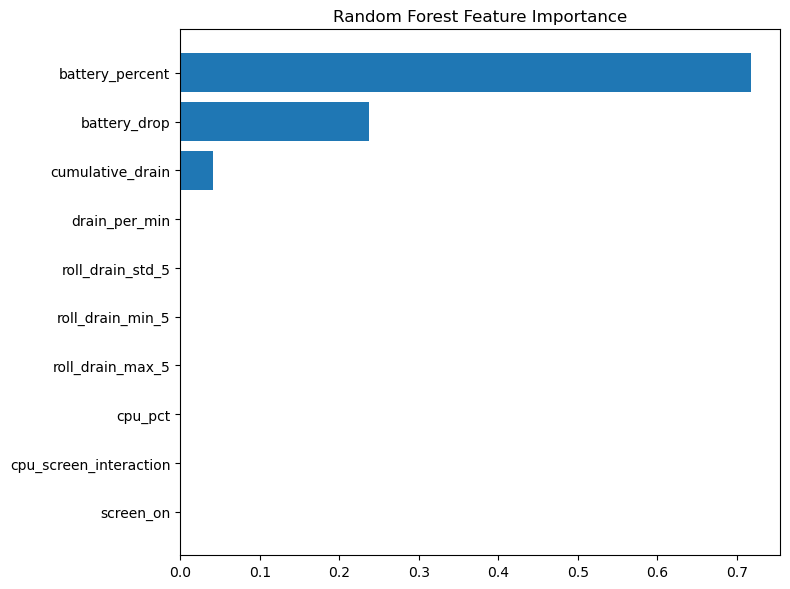

In [11]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()


In [12]:
features = [
    "battery_percent",
    "drain_per_min",
    "cpu_pct",
    "screen_on",
    "roll_drain_5",
    "roll_drain_10",
]

X = df[features]
y = df["minutes_remaining_target"]


KeyError: "['roll_drain_5', 'roll_drain_10'] not in index"

In [13]:
# Make sure df is your combined (light+medium+heavy) dataframe
# Add rolling mean features
df["roll_drain_5"] = df["drain_per_min"].rolling(5, min_periods=1).mean()
df["roll_drain_10"] = df["drain_per_min"].rolling(10, min_periods=1).mean()

df[["drain_per_min", "roll_drain_5", "roll_drain_10"]].head()


,drain_per_min,roll_drain_5,roll_drain_10
0,0.5216,0.521600,0.521600
1,0.5544,0.538000,0.538000
2,0.0944,0.390133,0.390133
3,0.1348,0.326300,0.326300
4,0.0765,0.276340,0.276340


In [14]:
features = [
    "battery_percent",
    "drain_per_min",
    "cpu_pct",
    "screen_on",
    "roll_drain_5",
    "roll_drain_10",
]

X = df[features]
y = df["minutes_remaining_target"]


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred)
mae_rf


92.54785185185186

In [16]:
df["session_encoded"] = df["session"].map({"light":0, "medium":1, "heavy":2})


In [17]:
features = [
    "battery_percent",
    "drain_per_min",
    "cpu_pct",
    "screen_on",
    "roll_drain_5",
    "roll_drain_10",
    "session_encoded",
]


In [18]:
X = df[features]
y = df["minutes_remaining_target"]

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred)
mae_rf


61.52839197530865